In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("../datasets/telco.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_cols = list(df.dtypes[df.dtypes=="object"].index)

for c in categorical_cols:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == "yes").astype(int)

In [3]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [6]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/home/henson/.local/share/virtualenvs/ml_zoomcamp-LPKXiwbL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [8]:
(y_val == 0).sum() / len(y_val)

np.float64(0.7260468417317246)

<p> IS THIS A GOOD ACCURACY? LET'S TRY USING MULTIPLE THRESHOLD

In [9]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.591
0.15 0.666
0.20 0.709
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.792
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


<p> The 0.5 threshold yields the best accuracy, but look, the other thershold doesn't really affect the accurary as much

<Axes: >

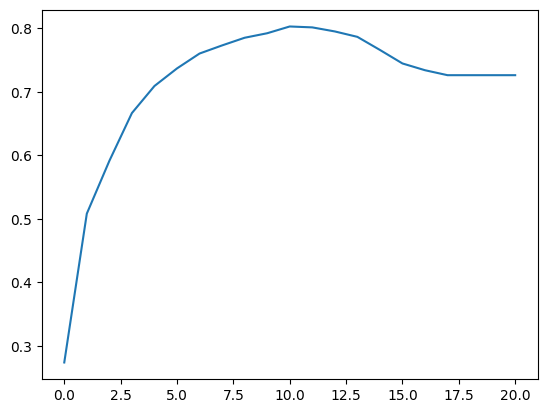

In [11]:
sns.lineplot(scores)

<p> Scikit learn has its own function to calculate accuracy

In [12]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.591
0.15 0.666
0.20 0.709
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.792
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


<p> This shows imbalance of the churn target value, which may significantly impact the accuracy
<p> Some alternative evaluation model is needed

In [60]:
# people who are going to churn
actual_positive = (y_val == 1)
# people who are not going to churn
actual_negative = (y_val == 0)

In [61]:
t = 1
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [62]:
# True positive (predicted churn & true churn)
tp = (predict_positive & actual_positive).sum()

# True negative (predicted no churn & true no churn)
tn = (predict_negative & actual_negative).sum()
 
# False positive (predicted churn & true no churn), also called type 1 error
fp = (predict_positive & actual_negative).sum()

# False negative (predicted no churn & true churn), also called type 2 error
fn = (predict_negative & actual_positive).sum()

In [63]:
fp, fn

(np.int64(0), np.int64(141))

In [64]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
 
confusion_matrix

array([[422,   0],
       [141,   0]])

In [65]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.75, 0.  ],
       [0.25, 0.  ]])

### PRECISION & RECALL

In [66]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

/tmp/ipykernel_1056/1607859269.py:2: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1. Precision: ratio of the predicted positive in regards to the total prediction (tp / (tp + fp))
2. Recall: ratio of the predicted positive in regards to the total real positive (tp / (tp + fn))

In [67]:
accuracy, precision, recall

(np.float64(0.7495559502664298), np.float64(nan), np.float64(0.0))

### Receiver Operating Characteristics (ROC)

In [21]:
# TRUE POSITIVE RATE == RECALL
tpr = tp / (fn + tp)

# FALSE POSITIVE RATE
fpr = fp / (tn + fp)

In [22]:
scores = []
thresholds = np.linspace(0, 1, 101)
 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
 
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
 
    scores.append((t, tp, tn, fp, fn))

In [23]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,107,916,1
2,0.02,384,192,831,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [24]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [25]:
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,666,357,53,0.862694,0.348974
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,921,102,176,0.544041,0.099707
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,75,1004,19,311,0.194301,0.018573
80,0.8,12,1022,1,374,0.031088,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


In [26]:
import matplotlib.pyplot as plt

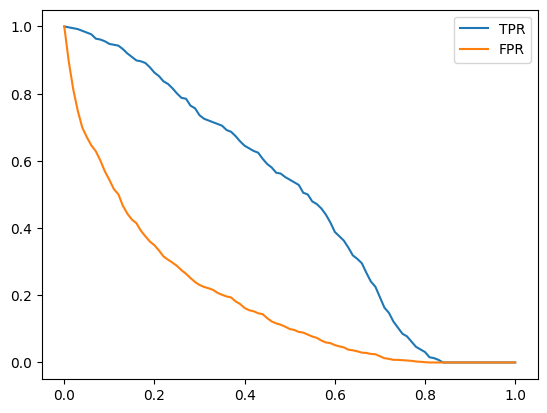

In [27]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

<p> Some random model

In [28]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [29]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [30]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
 
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
 
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
 
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
 
        scores.append((t, tp, tn, fp, fn))
 
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)
 
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
 
    return df_scores

In [31]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


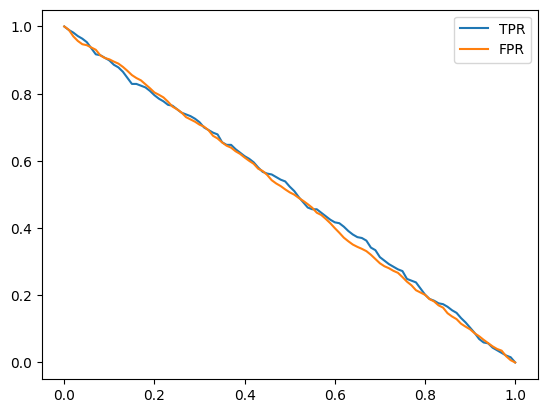

In [32]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

<p> Ideal Model -> This doesn't exist in reality, just for the sake of argument -> a model where tpr = 100% & fpr = 0 %

In [33]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [34]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [35]:
y_ideal_pred = np.linspace(0, 1, len(y_ideal))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [36]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [37]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal
# all prediction is correct

np.float64(1.0)

In [38]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


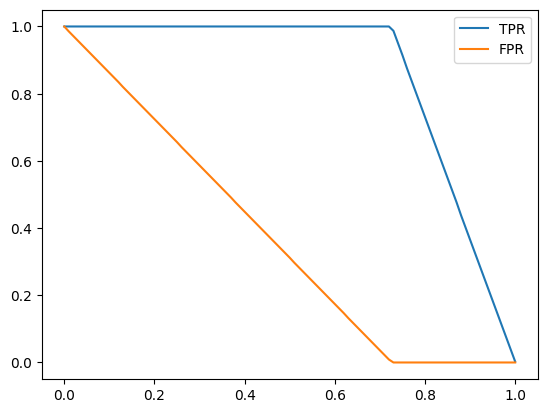

In [39]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

<p> TPR stays at 1.0 til a certain point, which is the threshold = 0.726
<p> While FPR starts at 1.0, and decreases as threshold increases & stays at 1.0 when threshold >= 0.726

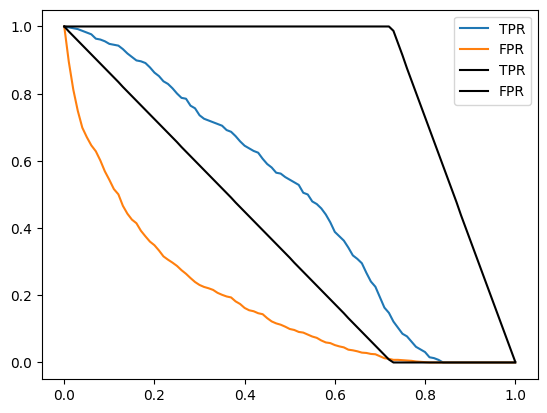

In [40]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
 
#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
 
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color = 'black')
 
plt.legend()

<p> Our TPR is far from ideal, so is our FPR
<p> Its ideal threshold is also different, 0.726 for ideal model & 0.5 for our model
<p> Let's plot TPR against FRP rather than against its threshold

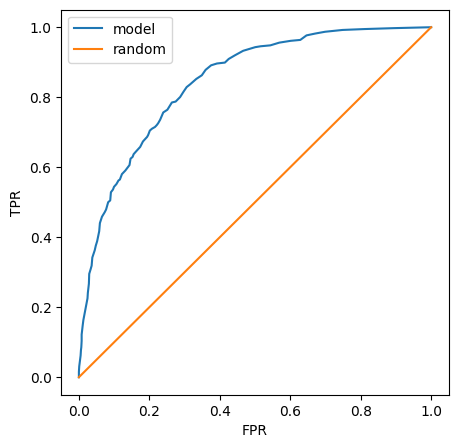

In [41]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

<p> We want our model to go to the north star, which is when TPR = 1.0 & FPR = 0.0

<p> Area Under the Curve (AUC)

<p>One way to quantify how close we are to the ideal point is by measuring the area under the ROC curve (AUC)

In [42]:
from sklearn.metrics import auc
# auc needs values for x-axis and y-axis
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8436415804375021)

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

np.float64(0.8438884921418767)

In [44]:
from sklearn.metrics import roc_auc_score
 
roc_auc_score(y_val, y_pred)

np.float64(0.8438884921418767)

In [69]:
y_pred

array([0.1838508 , 0.00487284, 0.64985359, 0.0758513 , 0.58892951,
       0.28999727, 0.28404743, 0.23923122, 0.00270292, 0.08343658,
       0.04983495, 0.012104  , 0.48324087, 0.72921502, 0.34275822,
       0.19390834, 0.6422543 , 0.28144016, 0.28540851, 0.03036299,
       0.67014135, 0.02398   , 0.00289171, 0.49241286, 0.74146568,
       0.08402468, 0.7216807 , 0.02832891, 0.67007762, 0.00993385,
       0.03686195, 0.00815112, 0.43752045, 0.57198208, 0.13181352,
       0.03032262, 0.51672887, 0.15010046, 0.76446235, 0.60612917,
       0.3168701 , 0.28937767, 0.73803417, 0.00709181, 0.00194516,
       0.5710318 , 0.41837751, 0.30412584, 0.0859226 , 0.48444857,
       0.0074747 , 0.00614941, 0.55119682, 0.59378021, 0.20421063,
       0.08476458, 0.00470393, 0.42959709, 0.01969742, 0.00377069,
       0.01814506, 0.70000522, 0.27483076, 0.06360601, 0.6417481 ,
       0.03038714, 0.72385498, 0.07815496, 0.18231008, 0.01585389,
       0.44764904, 0.39013345, 0.51471024, 0.19815044, 0.70297

<p> AUC tells us the probability that a randomly selected positive example has a score that is higher than a randomly selected negative example

In [45]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [46]:
import random
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

In [47]:
n = 100000
success = 0
 
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
 
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
 
success / n

0.84266

### CROSS VALIDATION

In [48]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression()
    model.fit(X_train, y_train)
 
    return dv, model

In [49]:
dv, model = train(df_train, y_train)

/home/henson/.local/share/virtualenvs/ml_zoomcamp-LPKXiwbL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [51]:
y_pred = predict(df_val, dv, model)

In [52]:
y_pred

array([0.00903433, 0.20609634, 0.21432726, ..., 0.1367152 , 0.79879739,
       0.83637349])

In [53]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

/home/henson/.local/share/virtualenvs/ml_zoomcamp-LPKXiwbL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/henson/.local/share/virtualenvs/ml_zoomcamp-LPKXiwbL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

In [54]:
scores

[np.float64(0.8478921171063722),
 np.float64(0.8410272277227723),
 np.float64(0.8557048652060528),
 np.float64(0.8339807423257345),
 np.float64(0.8276364764267989),
 np.float64(0.8372294372294372),
 np.float64(0.8409150113969392),
 np.float64(0.8186195445920303),
 np.float64(0.8452645620275677),
 np.float64(0.8622567308661895)]

In [55]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.841 +- 0.012


In [56]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)
 
    return dv, model

In [57]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.826 +- 0.012
C=0.01 0.841 +- 0.012
C=0.1 0.842 +- 0.012
C=0.5 0.843 +- 0.012
C=1 0.842 +- 0.012
C=5 0.842 +- 0.012
C=10 0.842 +- 0.012
